# Learning neural Lyapunov functions of dynamical systems

Objective of this tutorial is to learn nerual Lyapunov function used to certify the stability of a dynamical system from the observations of its trajectories. 
We choose to learn Lyapunov function candidate based on the architecture presented in the [paper](https://arxiv.org/abs/2001.06116).

**Learning setup**:  
System dynamics:         &emsp; &emsp;&emsp; &emsp; &emsp;&emsp;         $\frac{dx}{dt} = f(x); \,\,\, x \in R^n $  
Dataset of state trajectories: &emsp; &emsp;     $X = [x_1, ..., x_N] $  
Lyapunov function:   &emsp; &emsp;&emsp;&emsp;&emsp;&emsp;               $V(x): R^n \to R; \,\,\, V(0) = 0; \,\,\,  V(x) >0, \forall x \neq 0 $  
Lyapunov stability condition:  &emsp; &emsp;             $\frac{dV(x)}{dt} < 0 $  

[Lyapunov function](https://en.wikipedia.org/wiki/Lyapunov_function) , is a scalar function whose values can be interpreted as a potential energy stored in the system. Lyapunov functions are important notions in the control theory and [stability theory](https://en.wikipedia.org/wiki/Lyapunov_stability) of dynamical systems. For certain classes of ODEs, the existence of Lyapunov functions is a necessary and sufficient condition for stability. However, obtaining Lyapunov functions analytically for general class of systems is intractable, while existing computational methods such as [Sum of Squares method](https://ieeexplore.ieee.org/document/1470374) are intractable for larger systems. Hence, the presented tutorial provides a tractable alternative for learning neural Lyapunov function candidates from data.

**Illustration of a Lyapunov function**:  
<img src="./figs/Lyapunov.jpg" width="300">  

**Related academic papers**:  
+ [Learning Stable Deep Dynamics Models](https://arxiv.org/abs/2001.06116)
+ [Neural Lyapunov Control](https://arxiv.org/abs/2005.00611)
+ [The Lyapunov Neural Network: Adaptive Stability Certification for Safe Learning of Dynamical Systems](https://arxiv.org/abs/1808.00924)
+ [Neural Lyapunov Control of Unknown Nonlinear Systems with Stability Guarantees](https://arxiv.org/abs/2206.01913)
+ [LyaNet: A Lyapunov Framework for Training Neural ODEs](https://arxiv.org/abs/2202.02526)
+ [Neural Lyapunov Differentiable Predictive Control](https://ieeexplore.ieee.org/document/9992386)


## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [ ]:
!pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import neuromancer.psl as psl
from neuromancer.system import Node
from neuromancer.modules import blocks
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.plot import pltPhase

##  Obtain trajectories from the system 

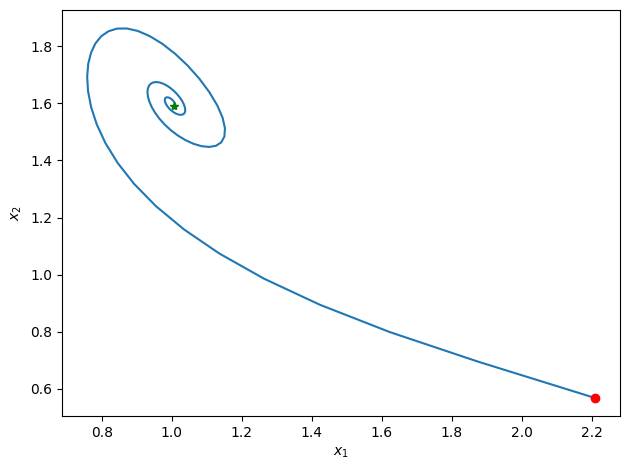

In [2]:
model = psl.autonomous.Brusselator1D(backend='numpy')

# select parameters
model.ts = 0.2
model.a = 1.0
model.b = 1.6

# problem dimensions and number of samples
nx = model.nx  # number of states
nsteps = 100  # rollout horizon
n_samples = 500  # number of sampled scenarios

# sample random initial conditions
init_cond = np.random.uniform(low=0.0, high=4.0, size=[n_samples, nx])
# obtain rollouts
Rollouts = []
for k in range(n_samples):
    rollout = model.simulate(nsim=nsteps, x0=init_cond[k, :])
    Rollouts.append(rollout['X'])
state_rollouts = np.stack(Rollouts)
# visualize single rollout
pltPhase(X=rollout['X'])

##  Construct datasets

We construct training and development datasets containing sequences of state trajectories, given as:  
$X_{\text{train/dev}} = [x^i_1, ..., x^i_N]$, $i = 1,...,m$.  
Where $N$ defines the length of the state trajectory rollout, and $m$ defines number of sampled trajectories.

In [3]:
# train/dev set ratio
train_ratio = 0.8
n_samples_train = int(n_samples*train_ratio)
X_train = torch.tensor(state_rollouts[:n_samples_train, :, :])
X_dev = torch.tensor(state_rollouts[n_samples_train:, :, :])
# Training dataset
train_data = DictDataset({'x': X_train}, name='train')
# Development dataset
dev_data = DictDataset({'x': X_dev}, name='dev')
# torch dataloaders
batch_size = 10
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           collate_fn=train_data.collate_fn,
                                           shuffle=False)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=batch_size,
                                         collate_fn=dev_data.collate_fn,
                                         shuffle=False)

##  Neural Lyapunov function candidate 

We instantiate a neural Lyapunov function candidate $V_{\theta}(x)$ parametrized by trainable parameters $\theta$ that satisfies the following Lyapunov function conditions:  
 $V_{\theta}(x): R^n \to R; \,\,\, V_{\theta}(0) = 0; \,\,\,  V_{\theta}(x) >0, \forall x \neq 0 $  
 
Specifically, we implement the architecture of the neural Lyapunov function candidate prestented in the [paper](https://arxiv.org/abs/2001.06116). The architecture consists of two layers, [Input convex neural network (ICNN)](https://arxiv.org/abs/1609.07152), and positive-definite layer.

**Input convex neural network (ICNN) layer**:  
$$
\begin{align}
&                     && z_1 = \sigma_0(W_0 x + b_0) \\
&                     && z_{i+1} = \sigma_i(U_i z_i + W_i x + b_i), \,\,\, i = 1, ..., k-1  \\
&                     && g(x) =  z_k  
\end{align}
$$  
Where $W_i$, and $b_i$ are real-valued weights and biases, respectively, while $U_i$ are positive weights, 
and $\sigma_i$ are convex, monotonically non-decreasing non-linear activations.
This neural layer guarantees that there are no local minima in the neural Lyapunov function candidate $V_{\theta}(x)$.

**Positive-definite layer**:  
$$
\begin{align}
&                     && V(x) = \sigma_{k+1}(g(x) - g(0)) + \epsilon ||x||^2_2
\end{align}
$$  
This layer guarantees the trivial null space of the Lyapunov function candidate, i.e.  $V_{\theta}(0) = 0$.


In [4]:
# Input convex neural network (ICNN)
g = blocks.InputConvexNN(nx, 1, hsizes=[20] * 4)

# strictly positive-definite layer if eps=0.0
lyap_net = blocks.PosDef(g, eps=0.0)
lyap_net.requires_grad_(True)  #  we want to learn all parameters, including steady-state offset

# symbolic wrapper for Lyapunov neural net
lyap_function = Node(lyap_net, ['x'], ['V'], name='Lyapunov')

##  Define objectives of the learning problem

The objective is to learn the Lyapunov function candidate $V_{\theta}(x)$ to satisfy the following discrete-time Lyapunov stability condition:  
$V_{\theta}(x_{k+1}) - V_{\theta}(x_k) < 0$

In [5]:
# variable: Lyapunov function value
V = variable("V")
# objective: discrete-time Lyapunov condition V(x_k+1) - V(x_k) < 0
Lyapunov_condition = V[:, 1:, :] - V[:, :-1, :] < - 0.01

# create constrained optimization loss
loss = PenaltyLoss(objectives=[Lyapunov_condition], constraints=[])
# construct optimization problem
problem = Problem(nodes=[lyap_function], loss=loss)
# plot computational graph
# problem.show()

##  Solving the problem with stochastic gradient descent

We use stochastic gradient descent to optimize the parameters $\theta$ of the Lyapunov function candidate $V_{\theta}(x)$ over the dataset of the state trajectories $X_{\text{train}}$.

In [6]:
optimizer = torch.optim.AdamW(problem.parameters(), lr=0.002)
#  Neuromancer trainer
trainer = Trainer(
    problem,
    train_loader, dev_loader, dev_loader,
    optimizer,
    epochs=200,
    train_metric='train_loss',
    eval_metric='dev_loss',
    warmup=200,
)
# Train control policy
best_model = trainer.train()
# load best trained model
trainer.model.load_state_dict(best_model)

epoch: 0  train_loss: 0.009836236014962196
epoch: 1  train_loss: 0.009576702490448952
epoch: 2  train_loss: 0.00944640301167965
epoch: 3  train_loss: 0.009370294399559498
epoch: 4  train_loss: 0.009260397404432297
epoch: 5  train_loss: 0.009139914996922016
epoch: 6  train_loss: 0.009043455123901367
epoch: 7  train_loss: 0.008976955898106098
epoch: 8  train_loss: 0.008935198187828064
epoch: 9  train_loss: 0.008914833888411522
epoch: 10  train_loss: 0.008893432095646858
epoch: 11  train_loss: 0.008874444290995598
epoch: 12  train_loss: 0.008852118626236916
epoch: 13  train_loss: 0.00885299313813448
epoch: 14  train_loss: 0.008831432089209557
epoch: 15  train_loss: 0.008827807381749153
epoch: 16  train_loss: 0.008813672699034214
epoch: 17  train_loss: 0.008806183002889156
epoch: 18  train_loss: 0.00879690982401371
epoch: 19  train_loss: 0.008798366412520409
epoch: 20  train_loss: 0.00879216380417347
epoch: 21  train_loss: 0.008779066614806652
epoch: 22  train_loss: 0.008778249844908714
ep

epoch: 184  train_loss: 0.0009175188024528325
epoch: 185  train_loss: 0.000754745677113533
epoch: 186  train_loss: 0.0010137080680578947
epoch: 187  train_loss: 0.0012566930381581187
epoch: 188  train_loss: 0.0013366166967898607
epoch: 189  train_loss: 0.0008986218017525971
epoch: 190  train_loss: 0.0007859651232138276
epoch: 191  train_loss: 0.0007560722879134119
epoch: 192  train_loss: 0.0008267235825769603
epoch: 193  train_loss: 0.0008429859881289303
epoch: 194  train_loss: 0.0009669471764937043
epoch: 195  train_loss: 0.0009395569795742631
epoch: 196  train_loss: 0.001165998401120305
epoch: 197  train_loss: 0.0016543302917852998
epoch: 198  train_loss: 0.0012993586715310812
epoch: 199  train_loss: 0.0009375676745548844


<All keys matched successfully>

## Visualize learned Lyapunov function with sampled trajectories

In [7]:
def plot_Lyapunov(net, trajectories=None, xmin=-2, xmax=2, save_path=None):
    # sample state sapce and get function values
    x = torch.arange(xmin, xmax, 0.1)
    y = torch.arange(xmin, xmax, 0.1)
    xx, yy = torch.meshgrid(x, y)
    features = torch.stack([xx, yy]).transpose(0, 2)
    uu = net(features)
    plot_u = uu.detach().numpy()[:,:,0]
    plot_x = xx.detach().numpy()
    plot_y = yy.detach().numpy()

    # plot surface of the lyapunov function
    fig = plt.figure()
    if trajectories is not None:
        ax1 = fig.add_subplot(121, projection="3d")
    else:
        ax1 = fig.add_subplot(111, projection="3d")
    ax1.plot_surface(plot_x, plot_y, plot_u,
                           cmap=cm.viridis,
                           linewidth=0, antialiased=False)
    # plot contours
    ax1.contour(plot_x, plot_y, plot_u, 20, offset=-1,
               cmap=cm.viridis, linestyles="solid")

    # plot minimum of the lyapunov function
    min_idx = np.where(plot_u == np.min(plot_u))
    point_u = plot_u[min_idx]
    point_x = plot_x[min_idx]
    point_y = plot_y[min_idx]
    ax1.scatter(point_x, point_y, point_u, color='red', s=100,
               marker='o')
    # set labels
    ax1.set(ylabel='$x_1$')
    ax1.set(xlabel='$x_2$')
    ax1.set(zlabel='$V$')
    ax1.set(title='neural Lyapunov function')

    # plot sample trajectory
    if trajectories is not None:
        # u_traj = net(trajectory)
        ax2 = fig.add_subplot(122)
        # plot contours
        ax2.contour(plot_x, plot_y, plot_u, 20, alpha=0.5,
                    cmap=cm.viridis, linestyles="solid")
        for i in range(trajectories.shape[0]):
            ax2.plot(trajectories[i, :, 1].detach().numpy(),
                    trajectories[i, :, 0].detach().numpy(),
                    'k--', linewidth=2.0, alpha=0.8,
                    label='sample trajectory')
        ax2.scatter(point_x, point_y, color='red', s=50,
                   marker='o')
        ax2.set_aspect('equal')
        # set labels
        ax2.set(ylabel='$x_1$')
        ax2.set(xlabel='$x_2$')
        ax2.set(title='Phase portrait')
        ax2.set_xlim([0., 4.])
        ax2.set_ylim([0., 4.])
        fig.tight_layout()

    plt.rcParams.update({'font.size': 20})
    if save_path is not None:
        plt.savefig(save_path+'/lyapunov.pdf')


C:\Users\drgo694\OneDrive - PNNL\Documents\anaconda3\envs\neuromancer\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


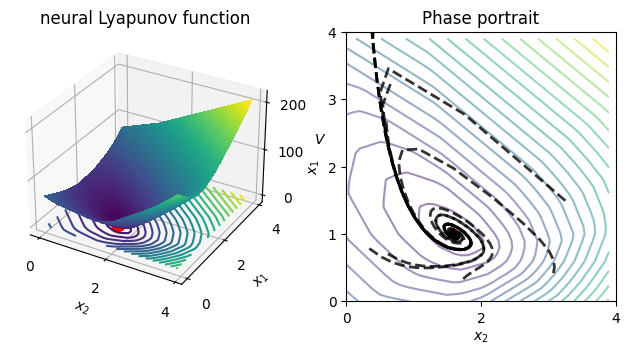

In [8]:
plot_Lyapunov(lyap_net, trajectories=X_train[0:10,:,:],
              xmin=0, xmax=4, save_path=None)